In [1]:
import os
from scipy import stats
import tempfile
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import rgb2hex
import pickle as pkl
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import sys
sys.path.append('../../CEBRA_analysis')
from dataset_load import data_load
from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
import seaborn as sns

In [2]:

delta_knn = pd.read_csv("~/ML_analysis/LDA_neural/mean_delta_knn_f1.csv", names=["feats", "delta_score"])
#delta_knn = pd.read_csv("~/ML_analysis/LDA_neural/mean_delta_knn_ng_f1.csv", names=["feats", "delta_score"])
delta_knn = delta_knn.iloc[1:]

In [3]:
delta_knn

,feats,delta_score
1,ECOG_LEFT_RawHjorth_Activity,0.014671
2,ECOG_LEFT_RawHjorth_Mobility,-0.002921
3,ECOG_LEFT_RawHjorth_Complexity,0.021688
4,ECOG_RIGHT_RawHjorth_Activity,0.006602
5,ECOG_RIGHT_RawHjorth_Mobility,0.012739
...,...,...
104,icoh_ECOG_RIGHT_to_ECOG_LEFT_mean_fband_high beta,-0.002367
105,icoh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_high beta,-0.000800
106,icoh_ECOG_RIGHT_to_ECOG_LEFT_mean_fband_high g...,-0.000777
107,icoh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_high gamma,0.010126


In [21]:
ord_idxs = np.argsort(delta_knn["delta_score"])[::-1]
ordered_feats = delta_knn["feats"].values[ord_idxs]
ordered_feats

array(['ECOG_RIGHT_bursts_high gamma_amplitude_mean',
       'ECOG_RIGHT_RawHjorth_Complexity',
       'ECOG_LEFT_RawHjorth_Complexity', 'ECOG_LEFT_fft_high beta',
       'ECOG_LEFT_RawHjorth_Activity',
       'ECOG_LEFT_Sharpwave_Max_prominence_range_5_30',
       'ECOG_RIGHT_RawHjorth_Mobility',
       'ECOG_LEFT_bursts_high beta_amplitude_max',
       'ECOG_LEFT_bursts_high beta_amplitude_mean',
       'icoh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_high gamma',
       'ECOG_RIGHT_bursts_low gamma_amplitude_mean',
       'ECOG_RIGHT_fft_high gamma',
       'ECOG_RIGHT_bandpass_activity_high gamma',
       'ECOG_RIGHT_bursts_high gamma_amplitude_max',
       'coh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_high gamma',
       'ECOG_RIGHT_fft_high beta',
       'ECOG_RIGHT_Sharpwave_Max_prominence_range_5_80',
       'ECOG_LEFT_stft_high beta', 'ECOG_LEFT_fft_high gamma',
       'ECOG_RIGHT_Sharpwave_Mean_interval_range_5_80',
       'ECOG_RIGHT_RawHjorth_Activity',
       'ECOG_LEFT_bursts_low beta_am

In [17]:
ord_idxs

108    90
107     5
106     2
105    29
104     0
       ..
5      25
4       1
3      17
2      27
1      87
Name: delta_score, Length: 108, dtype: int64

In [4]:
def split_quantify_lda(x, y, animals_id, run_id, idxs):
    groups = [a+i for a, i in zip(animals_id, run_id)]
    
    rng = np.random.default_rng(seed=42) 
    unique_groups = np.unique(groups)      
    rng.shuffle(unique_groups)   
    
    
    gkf = GroupKFold(n_splits=11)
    gkf.get_n_splits(groups=groups)
    
    X_unique = np.arange(len(unique_groups))
    
    perms = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X_unique, groups=unique_groups)):
    
        train_groups = unique_groups[train_idx]
        test_groups  = unique_groups[test_idx]
        
        train_mask = np.isin(groups, train_groups)
        test_mask  = np.isin(groups, test_groups)
        
        X_train, y_train = x.iloc[train_mask, idxs], y[train_mask]
        X_test,  y_test  = x.iloc[test_mask, idxs],  y[test_mask]
    
        clf = LinearDiscriminantAnalysis(store_covariance=True, n_components=2)
        clf.fit(X_train, y_train)
        perm = permutation_importance(clf, X_test, y_test, n_repeats=3, random_state=0)
        perms.append(perm)
    return perms

In [5]:
skipdates = ["220818", "220819"]
input_folder = "/sc-projects/sc-proj-cc15-ag-wenger-retune/data_kinematic_states_neural/"
VICON_FS = 200
variables_to_drop = ["ANIMAL_ID", "CONDITION", "RUN", "DATE", "EVENT", "ECOG_LEFT_fooof_a_knee", "ECOG_RIGHT_fooof_a_knee"]
data_dict = data_load(input_folder, variables_to_drop, skipdates)
x = data_dict["X_pd"]
y = data_dict["y_pd"]
animals_id = data_dict["animals_id_pd"]
run_id = data_dict["run_id_pd"]

No file found for 230425 NWE00161 02
No file found for 230425 NWE00161 08
No file found for 230425 NWE00160 04
No file found for 230425 NWE00160 03
No file found for 230425 NWE00164 21


In [6]:
s = slice(36, None)
perms = split_quantify_lda(x, y, animals_id, run_id, idxs=s)

In [7]:
perms_importance = pd.DataFrame(index=range(0,11), columns=x.iloc[:, s].columns)

for j, r in enumerate(perms):
    for i in r.importances_mean.argsort()[::-1]:
        perms_importance.loc[j, x.iloc[:, s].columns[i]] = r.importances_mean[i]

In [8]:
perms_lda = perms_importance.mean(axis=0)

In [9]:
perms_lda = perms_lda.to_frame(name="perms_lda")

In [10]:
scores = pd.concat([delta_knn.set_index("feats"), perms_lda], axis=1)

In [11]:
scores

,delta_score,perms_lda
ECOG_LEFT_RawHjorth_Activity,0.014671,0.011698
ECOG_LEFT_RawHjorth_Mobility,-0.002921,0.033915
ECOG_LEFT_RawHjorth_Complexity,0.021688,0.072634
ECOG_RIGHT_RawHjorth_Activity,0.006602,-0.000997
ECOG_RIGHT_RawHjorth_Mobility,0.012739,0.028385
...,...,...
icoh_ECOG_RIGHT_to_ECOG_LEFT_mean_fband_high beta,-0.002367,-0.000048
icoh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_high beta,-0.000800,0.000301
icoh_ECOG_RIGHT_to_ECOG_LEFT_mean_fband_high gamma,-0.000777,0.000428
icoh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_high gamma,0.010126,0.004651


ECOG_LEFT_RawHjorth_Complexity
ECOG_RIGHT_RawHjorth_Mobility
ECOG_LEFT_fft_high beta
ECOG_RIGHT_fft_high gamma


/tmp/ipykernel_3237991/2696880891.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = scores["delta_score"][i]
/tmp/ipykernel_3237991/2696880891.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = scores["perms_lda"][i]


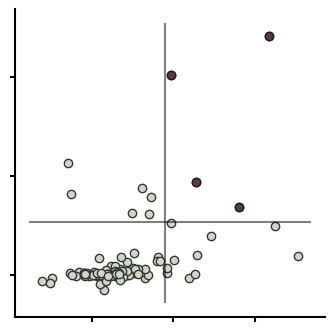

In [41]:
fig, ax = plt.subplots(figsize=(4,4))
x_th = 0.009
y_th = 0.016

ax.scatter(scores["delta_score"], scores["perms_lda"], color="#333c2a", facecolor="lightgray")#facecolor="#a4b494")

for i, label in enumerate(scores.index):
    x = scores["delta_score"][i]
    y = scores["perms_lda"][i]
    if x>x_th and y>y_th:
        print(label)
        #ax.annotate(label, (scores["delta_score"][i], scores["perms_lda"][i]), xytext=(5, 5), textcoords='offset points', fontsize=10)
        ax.scatter(x, y, color="#241920", facecolor="#543b4b")
ax.set_xticks([0, 0.01, 0.02], labels=[])
ax.set_yticks([0, 0.03, 0.06], labels=[])
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.vlines(x_th, ax.get_ylim()[0], ax.get_ylim()[1], color="k", alpha=0.5)
ax.hlines(y_th, ax.get_xlim()[0], ax.get_xlim()[1], color="k", alpha=0.5)
ax.tick_params(width=1.5)
plt.savefig("lda_v_cebra_offset200.svg", transparent=True)

In [14]:
cols = {"ECOG_LEFT_RawHjorth_Complexity":"#AC9ED1",
"ECOG_RIGHT_RawHjorth_Mobility":"#519872",
"ECOG_LEFT_stft_high beta":"#70163C", 
"ECOG_RIGHT_fft_high gamma": "#15467A"
       }